Saving datos_ventas_inf.csv to datos_ventas_inf.csv
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0955 - val_loss: 0.1079
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0568 - val_loss: 0.0694
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0320 - val_loss: 0.0460
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0268 - val_loss: 0.0317
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0200 - val_loss: 0.0236
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0175 - val_loss: 0.0185
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0186 - val_loss: 0.0162
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0192 - val_loss: 0.0157
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0186 - val_loss: 0.0158
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0185 - val_loss: 0.0167
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0208 - val_loss: 0.0179
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0244 - val_loss: 0.0188
E

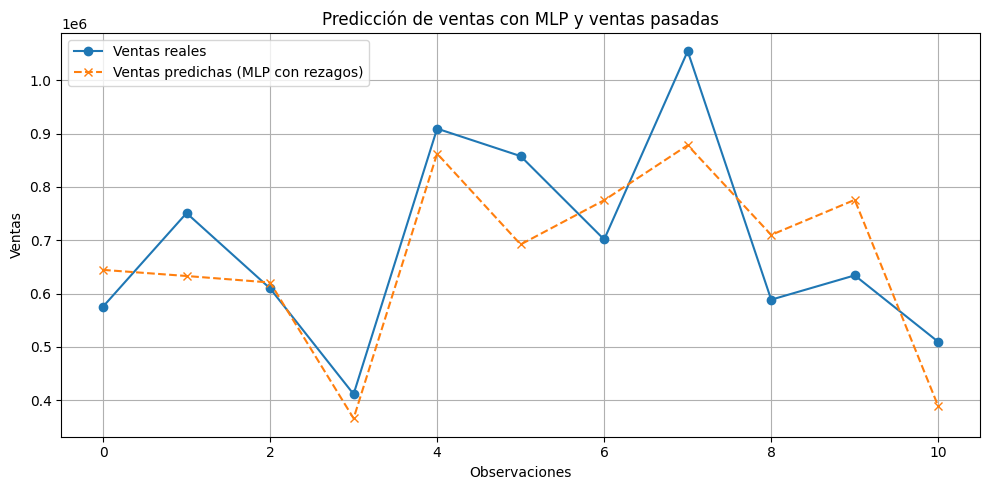

In [ ]:
import pandas as pd
from google.colab import files
import numpy as np

# Subí el archivo si no está cargado
uploaded = files.upload()

# Leer datos
df = pd.read_csv("datos_ventas_inf.csv")
df["fecha"] = pd.to_datetime(df["fecha"], format="%Y-%m")
df = df.sort_values("fecha")

# Crear columnas con ventas anteriores
df["venta_t-1"] = df["venta"].shift(1)
df["venta_t-2"] = df["venta"].shift(2)

# Eliminar filas con NaN por los shifts
df_modelo = df.dropna()

# Variables predictoras y target
X = df_modelo[["venta_t-1", "venta_t-2", "inflacion", "emae"]]
y = df_modelo["venta"]
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Escalar X e y
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

modelo_mlp_lag = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1)
])

modelo_mlp_lag.compile(optimizer='adam', loss='mse')
modelo_mlp_lag.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=1)
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Predicciones
y_pred_scaled = modelo_mlp_lag.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_real = scaler_y.inverse_transform(y_test)

# MAE real
mae = mean_absolute_error(y_real, y_pred)
print(f"🔹 MAE (MLP con rezagos, escala real): {mae:,.2f} unidades")

# Aplanar arrays por si hay dimensiones adicionales
y_real = y_real.flatten()
y_pred = y_pred.flatten()

# Evitar división por cero
non_zero = y_real != 0

# Calcular MAPE
mape = np.mean(np.abs((y_real[non_zero] - y_pred[non_zero]) / y_real[non_zero])) * 100

# Calcular BIAS
bias = np.mean(y_pred - y_real)

# Mostrar resultados
print(f"🔸 MAPE (MLP con rezagos): {mape:.2f}%")
print(f"🔸 BIAS (MLP con rezagos): {bias:,.2f} unidades")


# Gráfico
plt.figure(figsize=(10,5))
plt.plot(y_real, label="Ventas reales", marker='o')
plt.plot(y_pred, label="Ventas predichas (MLP con rezagos)", linestyle='--', marker='x')
plt.title("Predicción de ventas con MLP y ventas pasadas")
plt.xlabel("Observaciones")
plt.ylabel("Ventas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
